In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ast,json


In [4]:
def load_df(fname):
    df = pd.read_csv(fname)
    
    df["SN Undiagnosed"] = df["SN Untreated chronic"].values + df["SN Untreated acute"].values
    df["CN Undiagnosed"] = df["CN Untreated chronic"].values + df["CN Untreated acute"].values
    
    df["SN sample size"] = [len(ast.literal_eval(x)) - len(ast.literal_eval(y)) for x,y in zip(df["SN sampled"],df["SN seed"])] #df.apply(lambda x: x["SN sampled"].len())
    df["CN sample size"] = [len(ast.literal_eval(x)) - len(ast.literal_eval(y)) for x,y in zip(df["CN sampled"],df["CN seed"])]
    
    return df


def boxplots(fname):
    df = load_df(fname)
    df.boxplot(column=["SN sample size","CN sample size"],positions=[1,2],patch_artist=True,medianprops=dict(color="k"),notch=True)
    # df.boxplot(column=["SN sample size"],positions=[1],patch_artist=True,medianprops=dict(color="k"),notch=True)
    # box2 = df.boxplot(column=["CN sample size"],return_type="dict",positions=[2],patch_artist=True,medianprops=dict(color="k"),notch=True)
    # for item in ['boxes', 'whiskers', 'fliers', 'caps']:
    #     plt.setp(box2[item], color="darkred")
    plt.ylim([0,625])
    plt.show()
    
    df.boxplot(column=["SN GN count","CN GN count","SN TN count","CN TN count"],positions=[1,2,3,4],patch_artist=True,medianprops=dict(color="k"),notch=True)
    # df.boxplot(column=["SN GN count","SN TN count"],positions=[1,3],patch_artist=True,medianprops=dict(color="k"),notch=True)
    # box2 = df.boxplot(column=["CN GN count","CN TN count"],return_type="dict",positions=[2,4],patch_artist=True,medianprops=dict(color="k"),notch=True)
    # for item in ['boxes', 'whiskers', 'fliers', 'caps']:
    #     plt.setp(box2[item], color="darkred")
    plt.ylim([0,275])
    plt.show()

    df.boxplot(column=["SN sample size","SN HIV+","SN Out-of-care","SN Undiagnosed","CN sample size","CN HIV+","CN Out-of-care","CN Undiagnosed"],patch_artist=True,medianprops=dict(color="k"),notch=True)
    # df.boxplot(column=["SN HIV+"],positions=[1],patch_artist=True,medianprops=dict(color="k"),notch=True)
    # box2 = df.boxplot(column=["CN HIV+"],return_type="dict",positions=[2],patch_artist=True,medianprops=dict(color="k"),notch=True)
    # for item in ['boxes', 'whiskers', 'fliers', 'caps']:
    #     plt.setp(box2[item], color="darkred")
    plt.xticks(ticks=[1,2,3,4,5,6,7,8], labels=["SN size","SN HIV+","SN OOC","SN UD","CN size","CN HIV+","CN OOC","CN UD"])
    plt.ylim([0,625])
    plt.show()

    
def percentiles(fname):
    df = load_df(fname)
    SNdenom = np.median(df["SN sample size"].values)
    CNdenom = np.median(df["CN sample size"].values)
    SNhiv = np.median(df["SN HIV+"].values)
    CNhiv = np.median(df["CN HIV+"].values)
    SNooc = np.median(df["SN Out-of-care"].values)
    CNooc = np.median(df["CN Out-of-care"].values)
    SNud = np.median(df["SN Undiagnosed"].values)
    CNud = np.median(df["CN Undiagnosed"].values)
    props = {"SN HIV+" : SNhiv/SNdenom,"SN OOC" : SNooc/SNdenom,"SN UD" : SNud/SNdenom,"CN HIV+" : CNhiv/CNdenom,"CN OOC" : CNooc/CNdenom,"CN UD" : CNud/CNdenom}
    return props
    


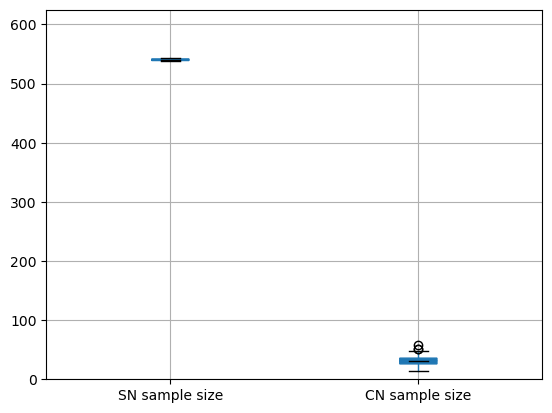

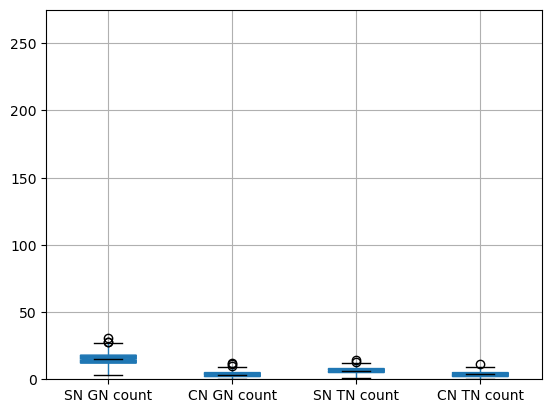

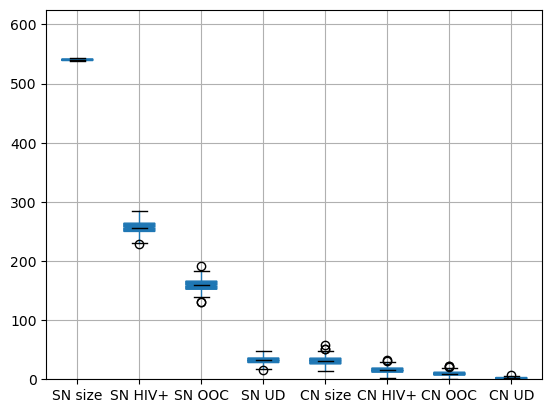

{'SN HIV+': 0.475, 'SN OOC': 0.29444444444444445, 'SN UD': 0.05925925925925926, 'CN HIV+': 0.4838709677419355, 'CN OOC': 0.2903225806451613, 'CN UD': 0.06451612903225806}


In [5]:
fname = "results_trimmed_end/JOB758832/all_summaries_20221031.csv"
boxplots(fname)
print(percentiles(fname))

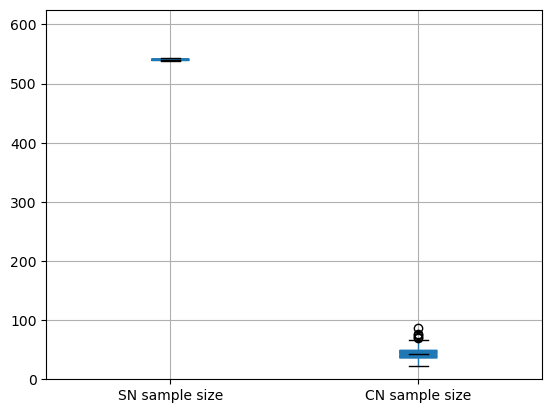

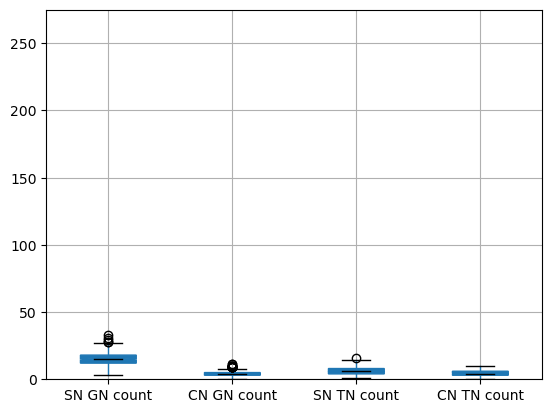

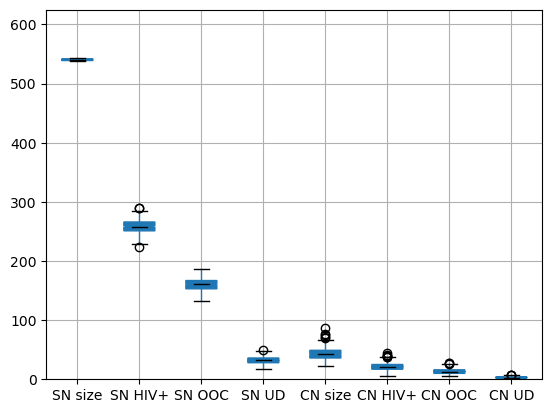

{'SN HIV+': 0.4777777777777778, 'SN OOC': 0.29814814814814816, 'SN UD': 0.05925925925925926, 'CN HIV+': 0.5, 'CN OOC': 0.30952380952380953, 'CN UD': 0.07142857142857142}


In [6]:
fname = "results_trimmed_end/JOB758832_RDS_contact/all_summaries_20221031contact.csv"
boxplots(fname)
print(percentiles(fname))

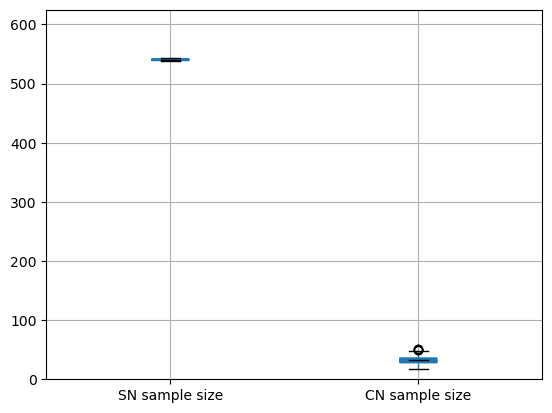

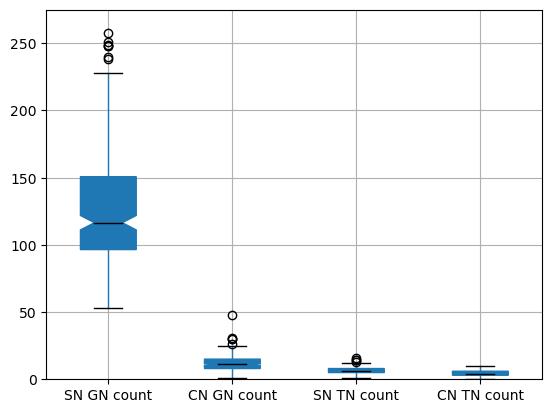

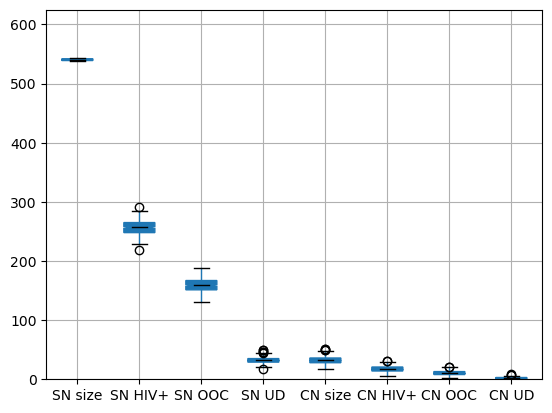

{'SN HIV+': 0.4759259259259259, 'SN OOC': 0.29444444444444445, 'SN UD': 0.05925925925925926, 'CN HIV+': 0.53125, 'CN OOC': 0.3125, 'CN UD': 0.0625}


In [7]:
fname = "results_trimmed_infection/JOB784278/all_summaries_20221101_infection.csv"
boxplots(fname)
print(percentiles(fname))